# Summary

This notebook contains the code necessary to recreate our analysis of the effects of genre and visual enhancements on the total gross income of a movie. 

There are two portions to our analysis:  
### [1. The effect of genre & visual enhancements on gross revenue](#The-effect-of-genre-&-visual-enhancements-on-gross-revenue) 

We explore these two categorical features in our datasets. First, we make recommendations for how a hypothetical Microsoft Film Studios should direct funds based on popular genres. Second, we analyze the popularity and earning power of visually enhanced films within the last eight years, and suggest how Microsoft could use their proprietary media and interactive hardware can create unique content in the video streaming product space.     

### [2. Rating and popularity vs. profit](#Rating-and-popularity-vs.-profit)

We normalize the raw user ratings by the number of total reviews a movie received. Using this data, we designate certain clusters of films that perform well with respect to popularity, net revenue, or both. Based on these findings, we suggest possible films that Microsoft could use as models to increase user popularity and profit. 

***
# Process

#### [1. Imports & Data Read-In](#1.-Imports-&-Data-Read-In)
#### [2. Cleaning](#2.-Cleaning)
#### [3. Subsetting](#3.-Subsetting)
#### [4. Analysis & Graphs](#4.-Analysis)
***

## 1. Imports & Data Read-In

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from helpers import *

%matplotlib inline
sns.set_style('darkgrid')

In [2]:
final_df = pd.read_csv('./data/final.csv')

#### Data Sources: [Movie Box Office](https://www.boxofficemojo.com/yearly/chart/?view2=worldwide&yr=2010&p=.htm) | [IMDB](https://www.imdb.com/interfaces/) | [TheNumbers.com](https://www.the-numbers.com/movie/budgets/all)

## 2. Cleaning

Once all our tables were merged, we followed this process below to clean our data.

### Generating total_gross column

In [3]:
# make sure domestic & foreign gross are both float types
final_df.domestic_gross = pd.to_numeric(final_df.domestic_gross, errors='coerce')
final_df.foreign_gross = pd.to_numeric(final_df.foreign_gross, errors='coerce')

# replace any gross na values with 0.0 (assuming an na means not presented domestically/internationally)
final_df.domestic_gross.fillna(0.0, inplace=True)
final_df.foreign_gross.fillna(0.0, inplace=True)

# add total_gross column, express value in billions
final_df['total_gross'] = final_df.domestic_gross + final_df.foreign_gross
final_df.total_gross = final_df.total_gross / 1_000_000_000

## 3. Subsetting

In [4]:
# drop repated movie listings that result in the same total_gross (these are just repeat listings)
unique_titles = final_df.drop_duplicates(subset=['primary_title', 'total_gross'])

# performant_genres: An ordered listing of the top 10 genre labels with the highest total_gross 
performant_genres = unique_titles.groupby("genres").sum().sort_values('total_gross', ascending=False).iloc[0:10, -1:]

# top subgenres: a cimple count of occurances of subgenres within the top performant genres
#     process subgenres
subgenres = get_subgenres(performant_genres.reset_index().genres)
top_subgenres = subgenre_counter(subgenres, performant_genres.reset_index())
#     Create subgenres dataframe
top_subgenres_df = pd.DataFrame(top_subgenres.items())
top_subgenres_df.columns = ["Genre", "Count"]
top_subgenres_df = top_subgenres_df.sort_values('Count', ascending=False)

# visually_enhanced: subset of movies with visual enhancements (3d or IMAX), grouped by genres
visually_enhanced = final_df[final_df.attributes.isin(['3-D version', 'IMAX version'])].sort_values('total_gross', ascending=False).loc[:, ["primary_title","total_gross"]]
top_visually_enhanced = visually_enhanced.groupby('primary_title').sum().sort_values('total_gross', ascending=False).iloc[:10, -1:]

# special_attributes: final_df grouped by attributes and sorted by total gross
special_attributes = final_df.groupby('attributes').sum().sort_values('total_gross', ascending=False)[0:12]

# three_d: a dataframe containing only films that had a 3D version. 
    # subset final_df by 3D versions
three_d = final_df[final_df.attributes == '3-D version']
    # count the number of 3D films per 
three_d_per_year = three_d.groupby('year').size()
split_3d = three_d
three_d = three_d.groupby('year').sum()
three_d['films_per_year'] = three_d_per_year
three_d['gross_by_num_films'] = three_d.total_gross / three_d.films_per_year

# imax: a dataframe containing only films that had a IMAX version
imax = final_df[final_df.attributes == 'IMAX version']
imax = imax.groupby('primary_title').sum()

## 4. Analysis
***


# The effect of genre & visual enhancements on gross revenue

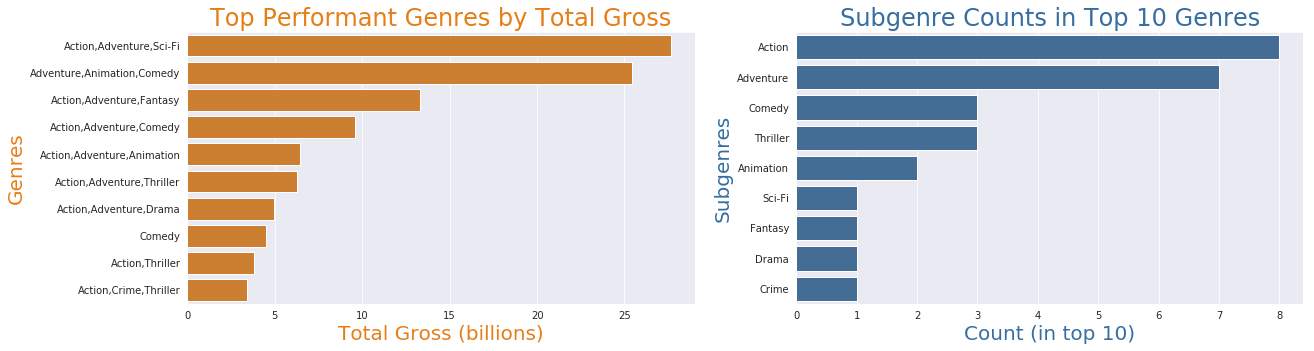

In [5]:
plot_genre_comparison(performant_genres, top_subgenres_df)

#### Analysis: 

Examination of the subgenres in the top 10 performant genres reveals the high yieled of action and adventure films. We can see  clearly with this these that both action and adeventure subgenres appear more than double the amount of times in the genre listings of the top performant genres.  

Our recommendation is that MS should direct its resources towards action and adventure movies to maximize profits.  

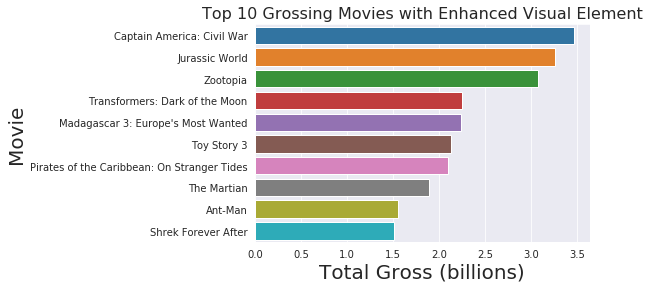

In [6]:
plot_top_visually_enhanced_movies(top_visually_enhanced)

#### Analysis: 

We believe it is wise for Microsoft to use its existing line of media hardware to help carve a distinguishable path in this crowded product landscape.  

The chart above shows gross income in billions of the top 10 highest grossing movies that had some visual enhancement (3D or IMAX versions). It is our suggestion that Microsoft use these films as models for further study to create similar productions that could also take advantage of their media technology. 
***

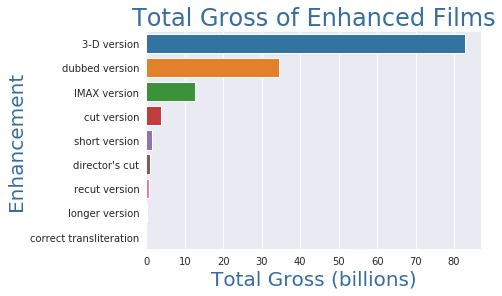

In [7]:
enhanced_attributes = final_df[final_df.attributes.str.contains("title|alt|promo")==False]
enhanced_attributes = enhanced_attributes.groupby('attributes').sum().sort_values('total_gross', ascending=False)

plot_enhanced_attributes(enhanced_attributes)

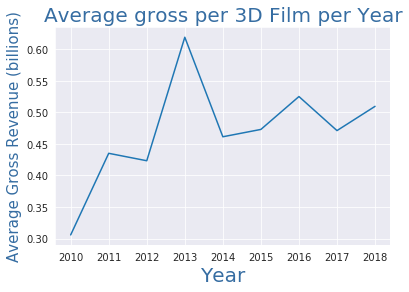

In [8]:
plot_3d_trend(three_d)

#### Analysis: 

(2nd graph)

Besides an anomalous spike in generated revenue in 2013, 3D films have experience a significant rise in gross profits since 2010, and have been holding relatively steady for the last 4 years. Given this trend and perceived staying power, the recommendation holds that Microsoft look into ways to use their proprietary technology to visually enhance their productions. 
***

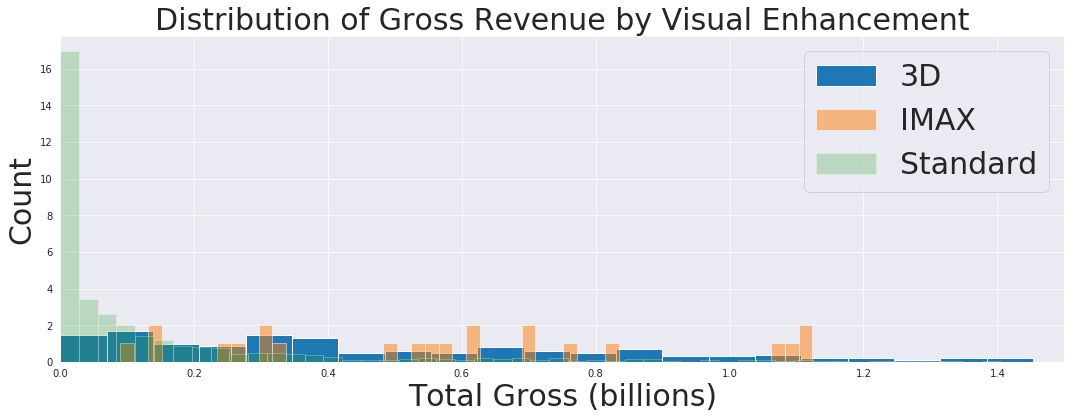

In [9]:
plot_visually_enhanced_revenue_distribution(split_3d, imax, final_df)

#### Analysis: 

As can be seen in this chart, the distribution of the earning potential of 3D and IMAX movies tends to be greater than those movies without some enhanced visual element.  

Because Microsoft has access to high-end, proprietary media and interactive hardware (Hololense, Xbox Kinect, etc.), they could provide more immersive viewing experiences for their viewers by integrating these technologies. The popularity and earning potential of 3D and IMAX films may suggest that these enhanced visuals may help to increase the viewer base and total gross revenue. 
***

# Rating and popularity vs. profit

Percent of rows left after first merge: 0.5053645719290563
Percent of rows left after second merge: 0.03886237986455621


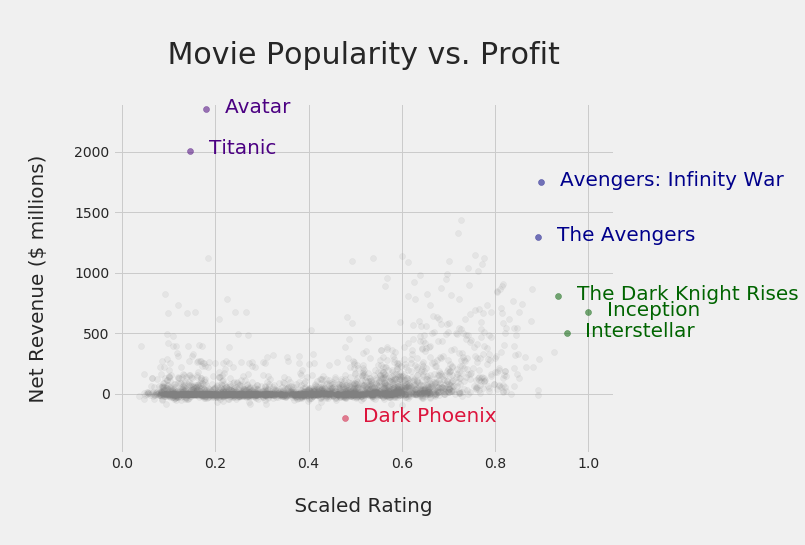

In [10]:
df = prepare_data_for_roi_analysis()
df = clean_data_prepare_features(df)
plot_popularity_vs_roi(df)

#### Analysis: 

This chart displays each movie's net revenue (calculated as worldwide gross revenue less the movie's production budget) plotted against its average individual user rating (calculated as average rating times the natural log of the total number of votes the movie received, scaled to be between 0 and 1). Overall, the dense clustering of movies along the lower end of the chart illustrates that most films do not generate much revenue. Some films are hugely profitable but receive low ratings; examples of these are Avatar and the Titanic (in the top left corner). Others are very popular with audience members, but are not as profitable; Interstellar, The Dark Night Rises and Inception fall into this category (bottom right corner). Some films - such as those in the Avengers series - score highly on both net revenue and rating (upper right corner). Finally, some films are associated with significant losses, including the recently released Dark Phoenix.

As a result, this chart illustrates trade-offs between profitability and popularity and could help guide Microsoft in terms of what areas the company wants to prioritize.

***